# Change in exposure to heatwaves

Heat waves are defined here using the index proposed in Jacob et al. [2013] modified to use daily minimum temperature data instead of maximum. Any period of more than 3 consecutive days (i.e 4 or more days) exceeding the 99th percentile of the daily minimum temperature of all DJF/JJA seasons for the recent past (1986-2005) is considered to be a heat wave. The change in heatwave frequency ∆H is the difference between the projected number of heat waves and the number of heat waves in the recent historic period (1986-2005).

To calculate the exposure of people to heatwave, we consider only the population over 65. This older population is more vulnerable to health impacts from heatwaves.
  
The heatwave risk H is measured as the change in heatwave frequency
∆H multiplied by the population:

$$
H = ∆H(x,t)P(x,t)
$$

where P(x,t) is the population of people aged over 65 at location x at time t.

This produces a 'heatwave exposure' indicator measured in heatwave-persons.


## Normalised length and frequency of heatwaves

In addition to the total exposure number, we also produce values for heatwave count and length normalised by total population. We calculate the length of heatwaves as the sum of days in a given heatwave. We compare this to the global average (when using gridded data, the average is calculated taking into account the relative area of each rectangular grid cell when projected to the spherical earth). This makes it possible to compare the mean change in heatwave lengths on average globally and the mean change in heatwave lengths experienced by people.


In [1]:
%matplotlib inline

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
# import geopandas as gpd

import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib as mpl

from scipy import stats
from numba import jit
from tqdm import tnrange, tqdm_notebook, tqdm

import population_tools

from config import DATA_SRC, POP_DATA_SRC, WEATHER_SRC

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

In [3]:
MAX_YEAR = 2018
REFERENCE_YEAR_START = 1986
REFERENCE_YEAR_END = 2005

RESULTS_FOLDER = Path('./results/lancet2019/1.2 heatwaves')
RESULTS_FOLDER.mkdir(parents=True, exist_ok=True)

POPULATION_FILE = POP_DATA_SRC / 'population_count_2000-2020_30min_era_compat.nc'
DEMOGRAPHICS_FILE = POP_DATA_SRC / 'demographic_pct_2010_30min_era_compat.nc'

# NOTE that we are now using 0.5 degree data (older versions used 0.75)
MIN_TEMPERATURES_FOLDER = WEATHER_SRC / 'era_interim_0.5deg' / 'summer_min_temperature'
CLIMATOLOGY_DAILY_FILE = WEATHER_SRC / 'era_interim_0.5deg' / 'climatology_daily_tmin_quantiles.nc'

# WISHLIST - instead of re-calculating the whole thing each year, would like to just add the newest year.
# For this would need to stablise the method though
# I'm not sure it's possible to 'fully' automate since e.g. the demographic data might need to change, GWPv4 is only until 2020
INTERMEDIATE_RESULTS_FOLDER = DATA_SRC / 'lancet'/ 'heatwaves'/ 'results_2019'


# TODO - should not need these anymore with the new gridded demographics
UN_DEMOGRAPHICS_FILE  = POP_DATA_SRC / 'UN' / 'WPP2017_PopulationByAgeSex_Medium.csv'
COUNTRY_SHAPEFILE = DATA_SRC / 'GIS' / 'world'/ 'ne_50m_admin_0_countries' / 'ne_50m_admin_0_countries.shp'

## Load population and demographic data

In [4]:
demographics = xr.open_dataarray(DEMOGRAPHICS_FILE)
fraction_over_65 = demographics.sel(age_band_lower_bound=65, drop=True).load()
population = xr.open_dataarray(POPULATION_FILE)

In [5]:
population_over_65 = population * fraction_over_65

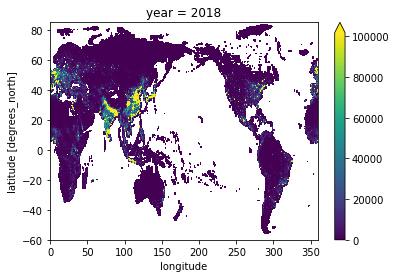

In [6]:
population_over_65.sel(year=MAX_YEAR).plot(robust=True)

## Load heatwave lengths and counts data

> TODO would like to split this up into yearly files so I only need to re-do one year at a time...

In [6]:
heatwaves_counts = xr.open_dataarray(INTERMEDIATE_RESULTS_FOLDER / 'heatwaves_counts_all_years.nc')
heatwaves_lengths = xr.open_dataarray(INTERMEDIATE_RESULTS_FOLDER / 'heatwaves_lengths_all_years.nc')

In [9]:
heatwaves_lengths_delta = xr.open_dataarray(INTERMEDIATE_RESULTS_FOLDER /'heatwaves_lengths_delta.nc')
heatwaves_counts_delta = xr.open_dataarray(INTERMEDIATE_RESULTS_FOLDER /'heatwaves_counts_delta.nc')

# Project the heatwave changes onto the population

## Change in experienced heatwave mean number of days

Calculate the change in the mean number of days of heatwave, as experienced by the vulnerable populations. Project the change in mean number of days of heatwaves onto the population over 65.

## Heatwaves lengths area mean compared population weighted mean

This is the main purely numeric indicator for heatwaves, since it delivers a simple metric that allows comparison between global average and population weighted average values in terms of number of days of heatwaves.

In [13]:
total_pop = population_over_65.sum(dim=['latitude', 'longitude'], skipna=True)

heatwaves_l_pop_ts = (heatwaves_lengths_delta * population_over_65 / total_pop).sum(dim=['latitude', 'longitude'], skipna=True)

In [25]:
# Plot the change in mean length of heatwaves over time, comparing the global average with the population weighted average
heatwaves_lengths_ts.plot(color='C1',label='Area weighted')
heatwaves_l_pop_ts.plot(color='C0',label='Exposure weighted')


anom_reg = stats.linregress(heatwaves_lengths_ts.year.values, heatwaves_lengths_ts.values)
anom_reg = (anom_reg.slope * heatwaves_lengths_ts.year) + anom_reg.intercept

exposures_reg = stats.linregress(heatwaves_l_pop_ts.year.values, heatwaves_l_pop_ts.values)
exposures_reg = (exposures_reg.slope * heatwaves_l_pop_ts.year) + exposures_reg.intercept

anom_reg.plot.line('--', color='C1', label='Global trend')
exposures_reg.plot.line('-.', color='C0', label='Exposure trend')

plt.xticks(list(range(2000, MAX_YEAR + 1, 2)))
plt.xlabel('Year')
plt.ylabel('Mean heatwaves length change (days)')
plt.legend()
plt.savefig(str(RESULTS_FOLDER / f'heatwaves_length_comp_2000-{MAX_YEAR}.png'), dpi=300, bbox_inches='tight')
plt.savefig(str(RESULTS_FOLDER / f'heatwaves_length_comp_2000-{MAX_YEAR}.pdf'), bbox_inches='tight')

In [26]:
# Save excel - TODO why are we doing this in the context manager?
heatwaves_lengths_ts.name = 'heatwave_lengths'
heatwaves_l_pop_ts.name = 'heatwave_lengths_pop'

with pd.ExcelWriter(RESULTS_FOLDER / 'heatwave_exposure.xlsx') as writer:
    output = heatwaves_lengths_ts.to_dataframe().join(heatwaves_l_pop_ts.to_dataframe())
    output.columns = ['Area weighted change (days)', 'Exposure weighted change (days)']

    output.to_excel(writer, sheet_name='heatwaves_lengths')

In [17]:
# Save results
heatwaves_l_pop_ts.to_netcdf(INTERMEDIATE_RESULTS_FOLDER / 'heatwave_l_change_pop.nc')

In [16]:
# Retrieve saved results
heatwaves_l_pop_ts = xr.open_dataarray(INTERMEDIATE_RESULTS_FOLDER / 'heatwave_l_change_pop.nc')

Map plots of heatwaves for reference

In [17]:
from cartopy import crs


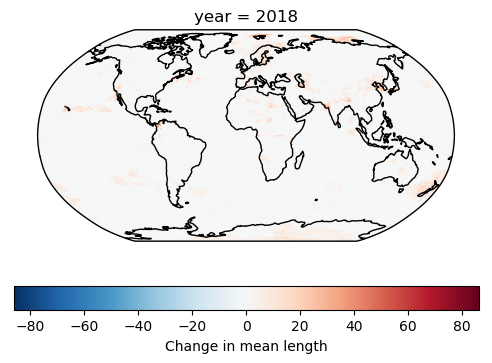

In [19]:
data = heatwaves_lengths_delta.sel(year=MAX_YEAR)

f = plt.figure( constrained_layout=False)
ax = plt.subplot(projection=crs.Robinson())
p = data.plot.pcolormesh(
    transform=crs.PlateCarree(),
    cbar_kwargs={'orientation':'horizontal','label':''}
)
p.colorbar.set_label('Change in mean length')

ax.coastlines()

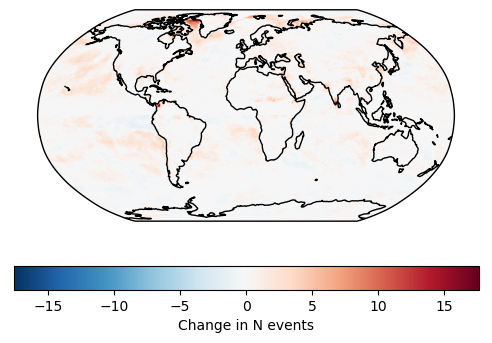

In [18]:
data = heatwaves_lengths_delta.mean(dim='year')

f = plt.figure( constrained_layout=False)
ax = plt.subplot(projection=crs.Robinson())
p = data.plot.pcolormesh(
    transform=crs.PlateCarree(),
    cbar_kwargs={'orientation':'horizontal',
                 'label':''}
)
p.colorbar.set_label('Change in mean length')

ax.coastlines()

# ax.set_title(f'''
# Mean change in number of extreme drought
# events over 2000 to {MAX_YEAR} period relative
# to {REFERENCE_YEAR_START}-{REFERENCE_YEAR_END} average''')


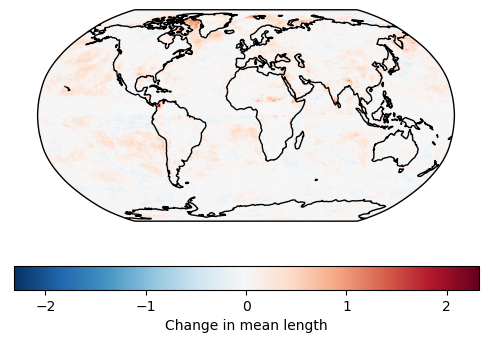

In [20]:
data = heatwaves_counts_delta.mean(dim='year')

f = plt.figure( constrained_layout=False)
ax = plt.subplot(projection=crs.Robinson())
p = data.plot.pcolormesh(
    transform=crs.PlateCarree(),
    cbar_kwargs={'orientation':'horizontal','label':''}
)
p.colorbar.set_label('Change in N events')

ax.coastlines()

## Change in exposure to heatwaves

Calculate the change in number of people exposed to heatwaves over time


## Plot the total number of exposure events where one exposure event = 1 person * 1 heatwave

- Also show the historical average (the baseline against which these are calculated)


In [27]:
# Calculate and the gridded exposure (useful for country specific work later)
heatwaves_pop_events = heatwaves_counts_delta * population_over_65

In [28]:
heatwaves_pop_events.to_netcdf(INTERMEDIATE_RESULTS_FOLDER / f'heatwave_exposure_events_change_2000-{MAX_YEAR}.nc')

In [21]:
heatwaves_pop_events = xr.open_dataarray(INTERMEDIATE_RESULTS_FOLDER / f'heatwave_exposure_events_change_2000-{MAX_YEAR}.nc')

In [29]:
heatwaves_pop_events_ts = heatwaves_pop_events.sum(dim=['latitude', 'longitude']).compute()

In [30]:
# Use the population count in 2000 as an approximation for the historical population
year = 2000
heatwave_events_historical = heatwaves_counts_historical* population_over_65.sel(year=year, drop=True) 
heatwave_events_historical = heatwave_events_historical.sum(dim=['latitude', 'longitude']).compute()

In [31]:
# heatwave_events_historical
np.asscalar(heatwave_events_historical) / 1e6

29.88268678527484

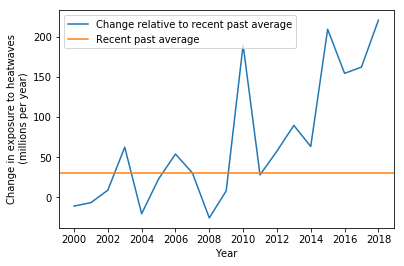

In [32]:
(heatwaves_pop_events_ts / 1e6).plot(label='Change relative to recent past average')
plt.axhline(np.asscalar(heatwave_events_historical) / 1e6, color='C1', label='Recent past average')
plt.xticks(list(range(2000, MAX_YEAR + 1, 2)))
plt.xlabel('Year')
plt.ylabel('Change in exposure to heatwaves\n (millions per year)')

plt.legend()
plt.savefig(str(RESULTS_FOLDER / f'heatwaves_n_exposure_2000-{MAX_YEAR}.png'), dpi=300)
plt.savefig(str(RESULTS_FOLDER / f'heatwaves_n_exposure_2000-{MAX_YEAR}.pdf'), bbox_inches='tight')

In [33]:
heatwaves_pop_events_ts / 1e6

<xarray.DataArray (year: 19)>
array([-10.785871,  -6.462032,   9.044195,  62.408812, -20.305559,  22.933698,
        53.937232,  30.503649, -25.466823,   8.152896, 189.596021,  28.053085,
        57.564364,  89.566405,  63.361871, 209.070975, 154.281986, 162.050051,
       220.286822])
Coordinates:
  * year     (year) int64 2000 2001 2002 2003 2004 ... 2014 2015 2016 2017 2018

In [34]:
# Save Excel
heatwaves_pop_events_ts.to_dataframe('heatwave_exposure_events').to_excel(RESULTS_FOLDER / f'heatwaves_n_exposure_change_2000-{MAX_YEAR}.xlsx')

Map plots

In [27]:
data = heatwaves_pop_events.sel(year=MAX_YEAR)


In [48]:
data = heatwaves_pop_events.sel(year=MAX_YEAR)
data = data.where(data != 0)
levels = np.hstack([-1*np.geomspace(1,4000000, 4)[::-1], np.geomspace(1,4000000, 4)])
# data = np.log(data.)

f = plt.figure( constrained_layout=False)
ax = plt.subplot(projection=crs.Robinson())
p = data.plot.pcolormesh(
    transform=crs.PlateCarree(),
    levels=levels,
    cbar_kwargs={'orientation':'horizontal',
                 'label':'',
#                   'spacing': 'proportional'
                }
)
p.colorbar.set_label('Change in exposures')

ax.coastlines()

# After standardisation on 0.5x0.5˚ grid, the results change slightly - illustrate this comparing previous years to this year

In [13]:
previous_heatwave_exposures = pd.read_csv('results/lancet2018/global//1.2 heatwaves/heatwaves_n_exposure_change_2000-2017.csv', index_col='year')

In [17]:
heatwaves_pop_events_ts = pd.read_excel(RESULTS_FOLDER / f'heatwaves_n_exposure_change_2000-{MAX_YEAR}.xlsx', index_col='year')

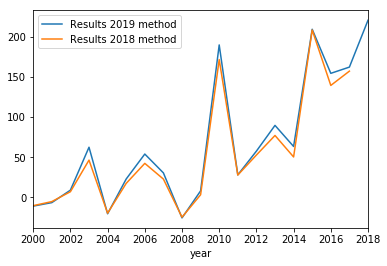

In [24]:
fig, ax = plt.subplots()
(heatwaves_pop_events_ts / 1e6).plot(
    label='Change relative to recent past average 2019',
    ax=ax
)
(previous_heatwave_exposures / 1e6).plot(
    label='Change relative to recent past average 2018',
    ax=ax
)
ax.legend(['Results 2019 method',
           'Results 2018 method'
])

fig.savefig(RESULTS_FOLDER / 'compare 2018 2019 method.png', dpi=300)